Processing audio from 10.00s to 30.00s
Selected duration: 20.00 seconds
Sample rate: 48000 Hz
Audio duration: 20.00 seconds
Number of channels: 1
Max amplitude: 0.282654
Min amplitude: 0.000000
Mean amplitude: 0.014143

RMS Energy Statistics:
Mean RMS: 0.018796
Median RMS: 0.007567
Standard Deviation RMS: 0.020877
10th percentile RMS: 0.000324
25th percentile RMS: 0.000621


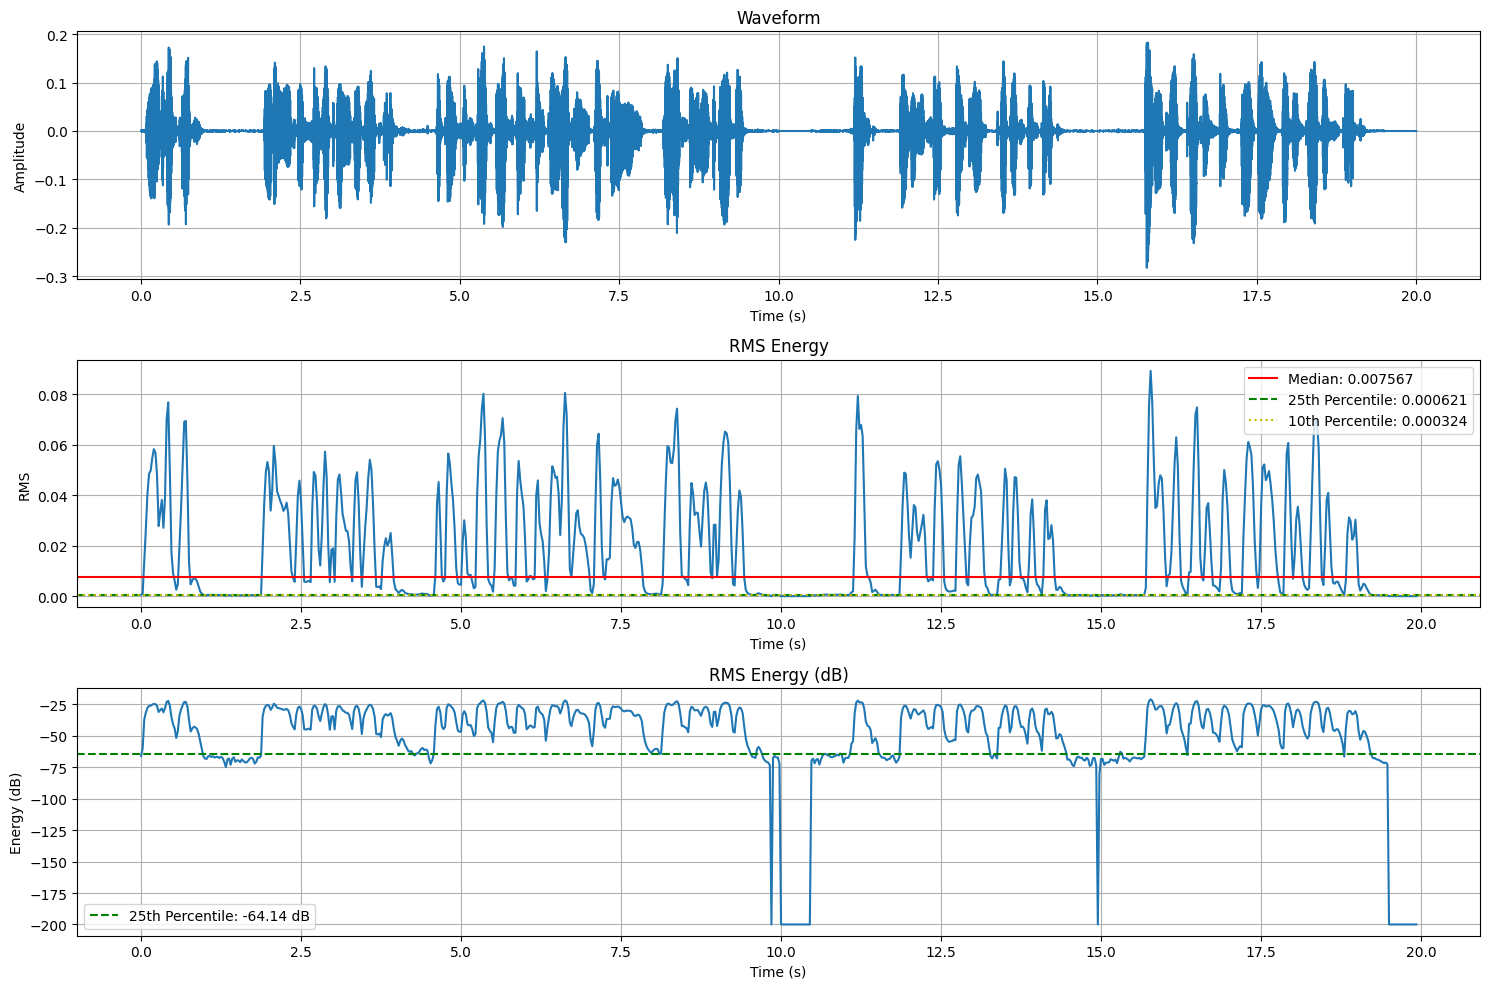


Silence segments using 25th percentile threshold:
Segment 1: 0.97s - 1.90s (duration: 0.92s)
Segment 2: 9.72s - 11.10s (duration: 1.38s)
Segment 3: 11.55s - 11.88s (duration: 0.32s)
Segment 4: 14.47s - 15.30s (duration: 0.83s)
Segment 5: 15.35s - 15.70s (duration: 0.35s)
Segment 6: 19.23s - 19.93s (duration: 0.70s)

Silence segments using 10th percentile threshold:
Segment 1: 9.97s - 10.47s (duration: 0.50s)
Segment 2: 19.38s - 19.93s (duration: 0.55s)


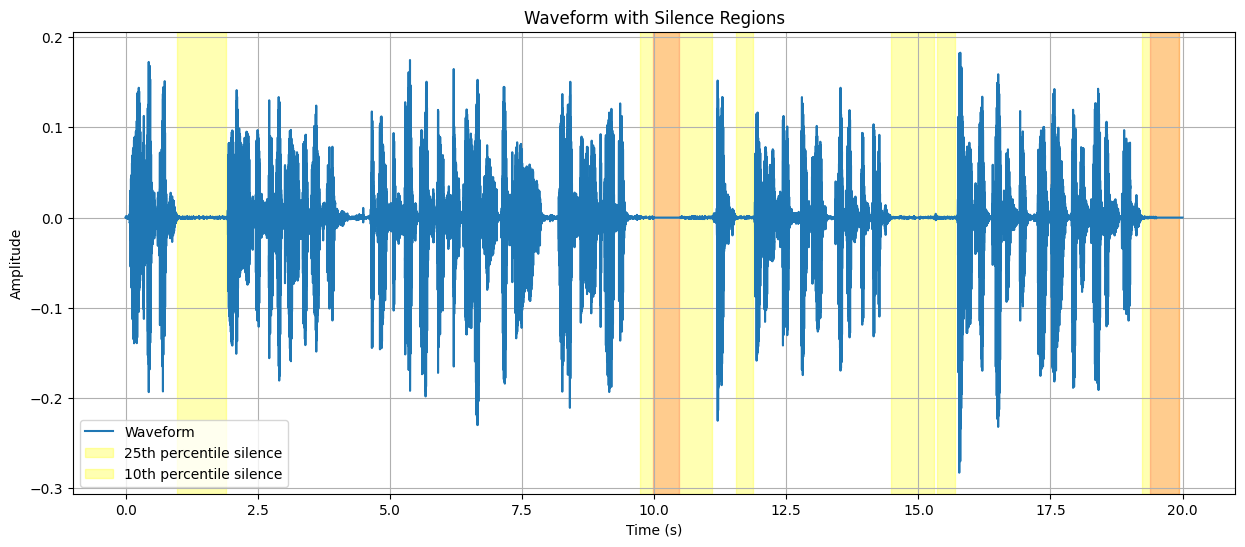


Splitting audio at silence points (25th percentile threshold):
Segment 1: 10.00s - 11.90s
Segment 2: 11.90s - 21.10s
Segment 3: 21.10s - 21.88s
Segment 4: 21.88s - 25.30s
Segment 5: 25.30s - 25.70s
Segment 6: 25.70s - 29.93s
Segment 7: 29.93s - 30.00s
Created 7 segments in ../data/outputs/split_audio_silence

Splitting audio at silence points (10th percentile threshold):
Segment 1: 10.00s - 20.48s
Segment 2: 20.48s - 29.93s
Segment 3: 29.93s - 30.00s
Created 3 segments in ../data/outputs/split_audio_silence_strict


In [25]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio

# Load the audio file with time range parameters
audio_file = "../data/inputs/original-demo-speech.wav"
waveform, sample_rate = torchaudio.load(audio_file)

# Define start and end times in seconds (ss = start seconds, es = end seconds)
ss = 10.0  # start at 10 seconds
es = 30.0  # end at 30 seconds

# Convert time to samples and extract the specified portion
start_sample = int(ss * sample_rate)
end_sample = int(es * sample_rate)

# Make sure end_sample doesn't exceed the waveform length
end_sample = min(end_sample, waveform.shape[1])

# Extract the specified portion of the audio
waveform = waveform[:, start_sample:end_sample]

print(f"Processing audio from {ss:.2f}s to {es:.2f}s")
print(f"Selected duration: {waveform.shape[1] / sample_rate:.2f} seconds")

# Print basic audio information
print(f"Sample rate: {sample_rate} Hz")
print(f"Audio duration: {waveform.shape[1] / sample_rate:.2f} seconds")
print(f"Number of channels: {waveform.shape[0]}")
print(f"Max amplitude: {waveform.abs().max().item():.6f}")
print(f"Min amplitude: {waveform.abs().min().item():.6f}")
print(f"Mean amplitude: {waveform.abs().mean().item():.6f}")

# Calculate RMS (Root Mean Square) energy over time
window_size = int(0.05 * sample_rate)  # 50ms window
hop_length = int(0.025 * sample_rate)  # 25ms hop
rms_values = []
time_values = []

for i in range(0, waveform.shape[1] - window_size, hop_length):
    chunk = waveform[:, i : i + window_size]
    rms = torch.sqrt(torch.mean(chunk**2)).item()
    rms_values.append(rms)
    time_values.append(i / sample_rate)

# Convert to dB for better visualization
rms_db = 20 * np.log10(np.array(rms_values) + 1e-10)  # Add small value to avoid log(0)

# Calculate statistics on the RMS energy
rms_mean = np.mean(rms_values)
rms_median = np.median(rms_values)
rms_std = np.std(rms_values)
rms_percentile_10 = np.percentile(rms_values, 10)
rms_percentile_25 = np.percentile(rms_values, 25)

print("\nRMS Energy Statistics:")
print(f"Mean RMS: {rms_mean:.6f}")
print(f"Median RMS: {rms_median:.6f}")
print(f"Standard Deviation RMS: {rms_std:.6f}")
print(f"10th percentile RMS: {rms_percentile_10:.6f}")
print(f"25th percentile RMS: {rms_percentile_25:.6f}")

# Plot the waveform and RMS energy
plt.figure(figsize=(15, 10))

# Original waveform
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, waveform.shape[1] / sample_rate, waveform.shape[1]), waveform[0].numpy())
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

# RMS energy
plt.subplot(3, 1, 2)
plt.plot(time_values, rms_values)
plt.axhline(y=rms_median, color="r", linestyle="-", label=f"Median: {rms_median:.6f}")
plt.axhline(y=rms_percentile_25, color="g", linestyle="--", label=f"25th Percentile: {rms_percentile_25:.6f}")
plt.axhline(y=rms_percentile_10, color="y", linestyle=":", label=f"10th Percentile: {rms_percentile_10:.6f}")
plt.title("RMS Energy")
plt.xlabel("Time (s)")
plt.ylabel("RMS")
plt.legend()
plt.grid(True)

# RMS energy in dB
plt.subplot(3, 1, 3)
plt.plot(time_values, rms_db)
threshold_db = 20 * np.log10(rms_percentile_25 + 1e-10)  # Convert to dB
plt.axhline(y=threshold_db, color="g", linestyle="--", label=f"25th Percentile: {threshold_db:.2f} dB")
plt.title("RMS Energy (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Energy (dB)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Define a function to identify silence segments
def find_silence_segments(rms_values, time_values, threshold=None, min_silence_duration=0.3):
    if threshold is None:
        threshold = rms_percentile_25  # Use 25th percentile as default

    silence_segments = []
    in_silence = False
    silence_start = 0

    for i, rms in enumerate(rms_values):
        if rms < threshold and not in_silence:
            # Start of silence
            in_silence = True
            silence_start = time_values[i]
        elif rms >= threshold and in_silence:
            # End of silence
            silence_end = time_values[i]
            silence_duration = silence_end - silence_start
            if silence_duration >= min_silence_duration:
                silence_segments.append((silence_start, silence_end, silence_duration))
            in_silence = False

    # Check if we ended in a silence
    if in_silence and (time_values[-1] - silence_start) >= min_silence_duration:
        silence_segments.append((silence_start, time_values[-1], time_values[-1] - silence_start))

    return silence_segments


# Find silence segments using different thresholds
silence_segments_25 = find_silence_segments(rms_values, time_values, rms_percentile_25)
silence_segments_10 = find_silence_segments(rms_values, time_values, rms_percentile_10)

print("\nSilence segments using 25th percentile threshold:")
for i, (start, end, duration) in enumerate(silence_segments_25):
    print(f"Segment {i + 1}: {start:.2f}s - {end:.2f}s (duration: {duration:.2f}s)")

print("\nSilence segments using 10th percentile threshold:")
for i, (start, end, duration) in enumerate(silence_segments_10):
    print(f"Segment {i + 1}: {start:.2f}s - {end:.2f}s (duration: {duration:.2f}s)")

# Plot waveform with identified silence regions
plt.figure(figsize=(15, 6))
plt.plot(np.linspace(0, waveform.shape[1] / sample_rate, waveform.shape[1]), waveform[0].numpy())

# Highlight silence regions with 25th percentile threshold
for start, end, _ in silence_segments_25:
    plt.axvspan(start, end, color="yellow", alpha=0.3)

# Highlight silence regions with 10th percentile threshold
for start, end, _ in silence_segments_10:
    plt.axvspan(start, end, color="red", alpha=0.2)

plt.title("Waveform with Silence Regions")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(["Waveform", "25th percentile silence", "10th percentile silence"])
plt.grid(True)
plt.show()


# Modified split function to split at silence points
def split_at_silence(waveform, sample_rate, silence_segments, output_dir, start_offset=0.0):
    os.makedirs(output_dir, exist_ok=True)

    # Add 0 as the start point and the end of audio as the end point
    split_points = [0]
    for _, end, _ in silence_segments:
        split_points.append(int(end * sample_rate))
    if split_points[-1] < waveform.shape[1]:
        split_points.append(waveform.shape[1])

    # Ensure split points are unique and sorted
    split_points = sorted(set(split_points))

    # Split the audio at these points
    for i in range(len(split_points) - 1):
        start_sample = split_points[i]
        end_sample = split_points[i + 1]

        # Extract segment
        segment = waveform[:, start_sample:end_sample]

        # Save segment
        segment_filename = os.path.join(output_dir, f"segment_{i + 1}.wav")
        torchaudio.save(segment_filename, segment, sample_rate)

        print(
            f"Segment {i + 1}: {split_points[i] / sample_rate + start_offset:.2f}s - "
            f"{split_points[i + 1] / sample_rate + start_offset:.2f}s"
        )

    return len(split_points) - 1


# Split the audio using 25th percentile silence detection
output_dir = "../data/outputs/split_audio_silence"
print("\nSplitting audio at silence points (25th percentile threshold):")
num_segments = split_at_silence(waveform, sample_rate, silence_segments_25, output_dir, start_offset=ss)
print(f"Created {num_segments} segments in {output_dir}")

# Alternative: Use 10th percentile for stricter silence detection
output_dir_strict = "../data/outputs/split_audio_silence_strict"
print("\nSplitting audio at silence points (10th percentile threshold):")
num_segments_strict = split_at_silence(waveform, sample_rate, silence_segments_10, output_dir_strict, start_offset=ss)
print(f"Created {num_segments_strict} segments in {output_dir_strict}")


Processing audio: 30.00 seconds
Calculated silence threshold: 0.000197

Detected 3 silence regions:
  Silence 1: 8.97s - 9.92s (duration: 0.95s)
  Silence 2: 15.43s - 16.49s (duration: 1.06s)
  Silence 3: 28.99s - 29.89s (duration: 0.90s)


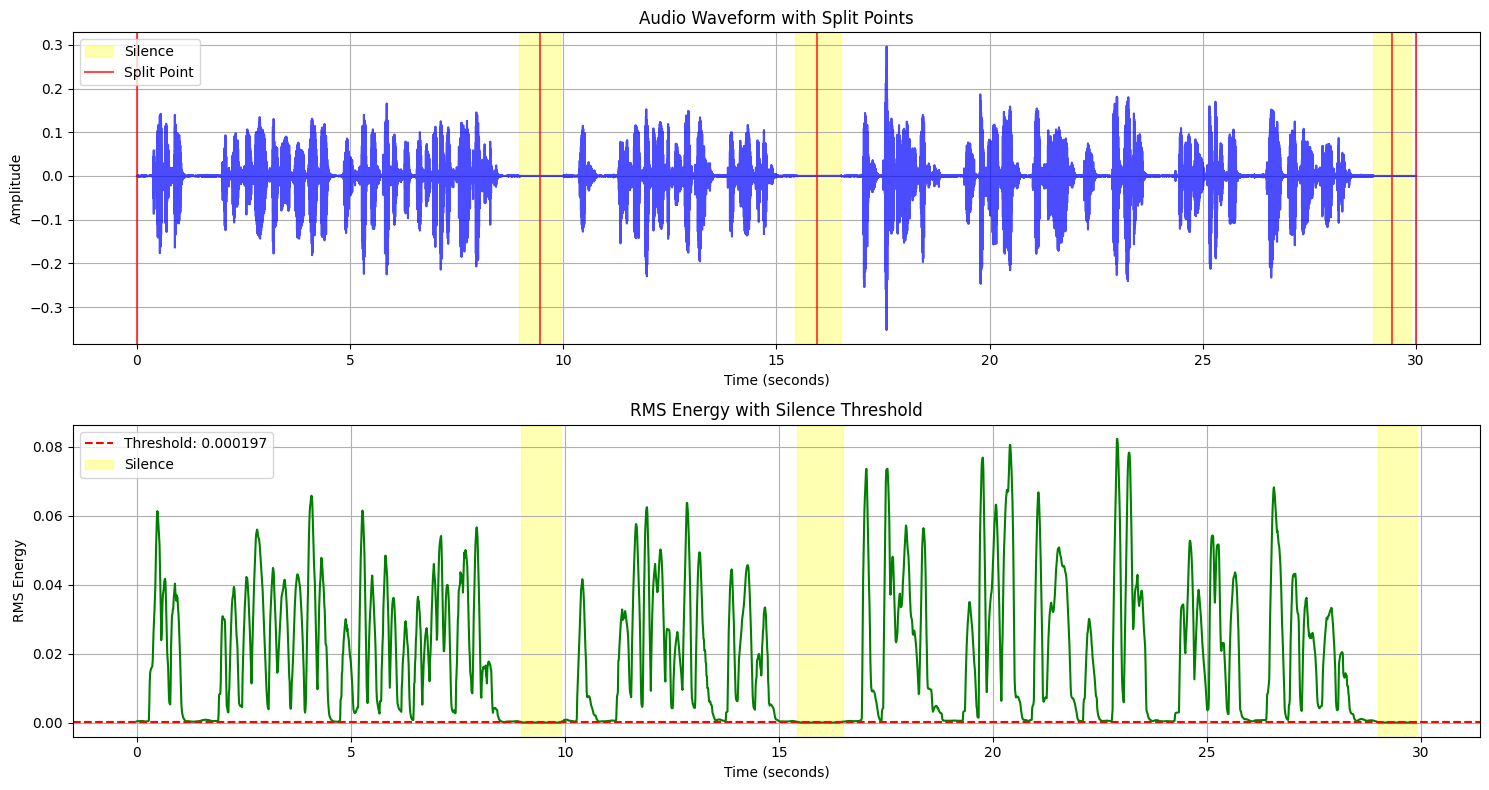

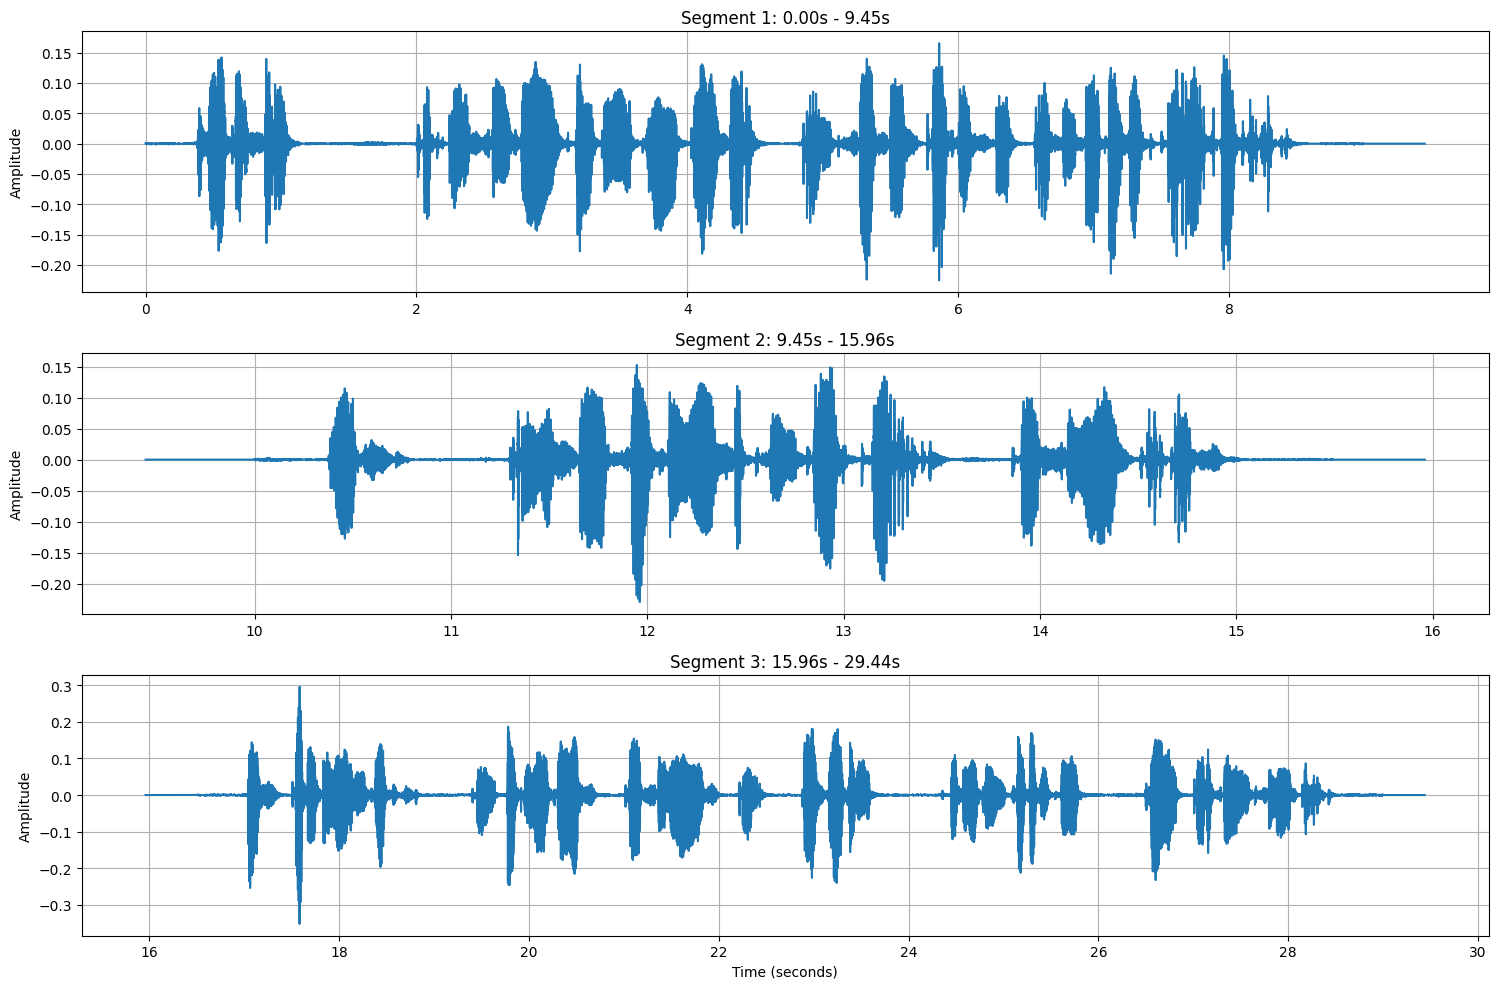

In [ ]:
import sys
sys.path.append('../src')

from claion.utils.audio_spliter import calculate_silence_threshold, calculate_rms, find_silence_regions, get_split_points, split_audio

def plot_waveform_with_splits(
    waveform: torch.Tensor,
    sample_rate: int,
    silence_regions: list[tuple[int, int]],
    split_points: list[int],
    rms_values: list[float] | None = None,
    time_points: list[int] | None = None,
    silence_threshold: float | None = None,
) -> None:
    """
    Plot waveform with silence regions and split points.

    Args:
        waveform: Audio waveform tensor
        sample_rate: Sample rate of the audio
        silence_regions: List of (start, end) tuples marking silence regions
        split_points: List of split points in samples
        rms_values: List of RMS energy values (optional)
        time_points: List of time points for RMS values (optional)
        silence_threshold: Silence threshold value (optional)
    """
    duration = waveform.shape[1] / sample_rate

    # Convert split points to timestamps
    split_timestamps = [p / sample_rate for p in split_points]

    # Initialize the plot
    plt.figure(figsize=(15, 8))

    # Plot the waveform
    time_axis = np.linspace(0, duration, waveform.shape[1])
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, waveform[0].numpy(), color="blue", alpha=0.7)
    plt.title("Audio Waveform with Split Points")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")

    # Mark the silence regions
    for i, (start, end) in enumerate(silence_regions):
        start_time = start / sample_rate
        end_time = end / sample_rate
        plt.axvspan(start_time, end_time, color="yellow", alpha=0.3, label="Silence" if i == 0 else None)

    # Mark the split points with vertical lines
    for i, split_time in enumerate(split_timestamps):
        if i == 0 or i == len(split_timestamps) - 1:
            plt.axvline(x=split_time, color="red", linestyle="-", alpha=0.7, label="Split Point" if i == 0 else None)
        else:
            plt.axvline(x=split_time, color="red", linestyle="-", alpha=0.7)

    plt.legend()
    plt.grid(True)

    # Plot RMS energy with threshold if provided
    if rms_values is not None and time_points is not None:
        plt.subplot(2, 1, 2)
        time_rms = [t / sample_rate for t in time_points]
        plt.plot(time_rms, rms_values, color="green")

        if silence_threshold is not None:
            plt.axhline(y=silence_threshold, color="red", linestyle="--", label=f"Threshold: {silence_threshold:.6f}")

        # Mark the silence regions
        for i, (start, end) in enumerate(silence_regions):
            start_time = start / sample_rate
            end_time = end / sample_rate
            plt.axvspan(start_time, end_time, color="yellow", alpha=0.3, label="Silence" if i == 0 else None)

        plt.title("RMS Energy with Silence Threshold")
        plt.xlabel("Time (seconds)")
        plt.ylabel("RMS Energy")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_segments(
    waveform: torch.Tensor, sample_rate: int, segment_info: list[tuple[int, int]], max_segments: int = 4
) -> None:
    """
    Plot individual audio segments.

    Args:
        waveform: Audio waveform tensor
        sample_rate: Sample rate of the audio
        segment_info: List of (start, end) tuples for segments
        max_segments: Maximum number of segments to display
    """
    plt.figure(figsize=(15, 10))
    n_segments = len(segment_info)
    n_rows = min(n_segments, max_segments)  # Limit to max_segments rows

    for i, (start, end) in enumerate(segment_info):
        if i < n_rows:  # Only show first few segments if there are many
            plt.subplot(n_rows, 1, i + 1)
            segment_time = np.linspace(start / sample_rate, end / sample_rate, end - start)
            plt.plot(segment_time, waveform[0, start:end].numpy())
            plt.title(f"Segment {i + 1}: {start / sample_rate:.2f}s - {end / sample_rate:.2f}s")
            plt.ylabel("Amplitude")

            if i == n_rows - 1:
                plt.xlabel("Time (seconds)")

            plt.grid(True)

    plt.tight_layout()
    plt.show()


def process_audio(
    audio_file: str,
    output_dir: str,
    ss: float = 0.0,
    es: float | None = None,
    threshold_method: str = "percentile",
    threshold_value: float = 10,
    min_silence_length: float = 0.5,
    min_segment_length: float = 1.0,
    split_method: str = "middle",
    window_size: float = 0.05,
    hop_length: float = 0.025,
    plot: bool = True,
) -> tuple[list[tuple[int, int]], float]:
    """
    Process an audio file to find silence regions and split it.

    Args:
        audio_file: Path to the audio file
        output_dir: Directory to save the split audio segments
        ss: Start time in seconds
        es: End time in seconds (None = end of file)
        threshold_method: Method to calculate silence threshold ('percentile', 'mean_fraction', or 'fixed')
        threshold_value: Value to use with the threshold method
        min_silence_length: Minimum silence length in seconds
        min_segment_length: Minimum segment length in seconds
        split_method: Method to determine split points ('middle', 'start', or 'end')
        window_size: Size of the analysis window in seconds
        hop_length: Hop length between windows in seconds
        plot: Whether to generate plots

    Returns:
        tuple: (segment_info, silence_threshold)
    """
    # Load audio file
    waveform, sample_rate = torchaudio.load(audio_file)

    # Process specific range if requested
    start_sample = int(ss * sample_rate)
    if es is not None:
        end_sample = min(int(es * sample_rate), waveform.shape[1])
    else:
        end_sample = waveform.shape[1]

    waveform = waveform[:, start_sample:end_sample]
    duration = (end_sample - start_sample) / sample_rate
    print(f"Processing audio: {duration:.2f} seconds")

    # Calculate RMS energy with window_size and hop_length parameters
    rms_values, time_points = calculate_rms(waveform, sample_rate, window_size, hop_length)

    # Calculate silence threshold
    silence_threshold = calculate_silence_threshold(rms_values, threshold_method, threshold_value)
    print(f"Calculated silence threshold: {silence_threshold:.6f}")

    # Find silence regions
    silence_regions = find_silence_regions(rms_values, time_points, sample_rate, silence_threshold, min_silence_length)
    print(f"\nDetected {len(silence_regions)} silence regions:")
    for i, (start, end) in enumerate(silence_regions):
        start_time = start / sample_rate
        end_time = end / sample_rate
        print(f"  Silence {i + 1}: {start_time:.2f}s - {end_time:.2f}s (duration: {end_time - start_time:.2f}s)")

    # Get split points
    split_points = get_split_points(silence_regions, waveform.shape[1], split_method)

    # Split audio
    segment_info = split_audio(waveform, sample_rate, split_points, output_dir, min_segment_length)

    # Plot results if requested
    if plot:
        plot_waveform_with_splits(
            waveform, sample_rate, silence_regions, split_points, rms_values, time_points, silence_threshold
        )

        if segment_info:
            plot_segments(waveform, sample_rate, segment_info)

    return segment_info, silence_threshold


# Example usage
if __name__ == "__main__":
    # Parameters
    audio_file = "../data/inputs/original-demo-speech.wav"
    output_dir = "../data/outputs/split_segments"

    # Process the audio
    segment_info, silence_threshold = process_audio(
        audio_file=audio_file,
        output_dir=output_dir,
        ss=30.0,  # start time
        es=60.0,  # end time (None = end of file)
        threshold_method="percentile",
        threshold_value=20,  # 10th percentile for silence threshold
        min_silence_length=0.5,  # minimum silence length in seconds
        min_segment_length=1.0,  # minimum segment length in seconds
        split_method="middle",  # split in the middle of silence regions
        window_size=0.1,  # window size in seconds for RMS calculation
        hop_length=0.01,  # hop length in seconds for RMS calculation
        plot=True,  # generate plots
    )